In [60]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

from macd import MACD, compute_portfolio, run_macd_hyperparam_search, run_macd_hyperparam_search_with_regimes, generate_position
from performance_metrics import compute_performance_metrics
from regime_clustering import compute_regime_clusters, assign_regimes

In [2]:
from lets_plot import *
LetsPlot.setup_html()

# 1. Exploratory Data Analysis

In [3]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12

In [4]:
spy =\
(
    yf.
    download(
        "^GSPC",
        start = start_date,
        end = end_date
    )
)

spy.columns =\
(
    spy
    .columns
    .droplevel(1) # level 0 --> Price; level 1 --> Ticker
)

spy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000


In [5]:
df = spy.copy()
split_idx = int(len(df) * 0.75)

df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

In [6]:
def generate_passive_returns(df: pd.DataFrame):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df['Close']
            /
            df['Close'].shift(1)
            )
    )

    df['cumulative_passive_returns'] =\
    (
        np.exp(
            df['passive_returns']
            .fillna(0)
            .cumsum()
        )
    )
    return df

In [7]:
df_train = generate_passive_returns(df_train)
df_test = generate_passive_returns(df_test)

In [8]:
df_train.shape

(3591, 7)

In [9]:
df_train

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns
Date,,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN,1.000000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,-0.000344,0.999656
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,-0.002226,0.997434
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,0.011283,1.008751
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,0.002215,1.010988
...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.013803,2.797399
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.001008,2.800221
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.010795,2.830612


In [10]:
df_test.shape

(1197, 7)

In [11]:
def plot_returns(df, y,
                date_column = 'Date',
                returns_column = 'cumulative_passive_returns'):
    
    melted = (
        df[[date_column, returns_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={returns_column: "blue"})
        + labs(
            title="Cumulative Returns",
            x="Date",
            y=y,
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [12]:
plot_returns(
    df=df_train.reset_index(),
    y='Training Returns'
)

In [13]:
plot_returns(
    df=df_test.reset_index(),
    y='Testing Returns'
)

# 2. Strategies

In [14]:
starting_capital = 100_000.0

In [15]:
combined_results = []

In [16]:
df_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns
Date,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,NaN,1.000000
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,-0.000345,0.999655
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.001661,1.001317
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.004700,1.006034
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,-0.000569,1.005461
...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875


## 2.1 Buy and Hold

In [17]:
buy_and_hold = \
(
    compute_performance_metrics(
        log_returns=df_test['passive_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Buy and Hold'
    )
)
print(buy_and_hold)

               CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Buy and Hold  0.125       0.171         0.254         0.776          1.273   

              Calmar Ratio  Final Portfolio Value  Cumulative Return  
Buy and Hold         0.492             175160.243              1.752  


In [18]:
combined_results.append(buy_and_hold)

## 2.1 Baseline MACD

In [19]:
baseline_macd = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=False)
baseline_macd = compute_portfolio(
    df = baseline_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,12_ewma,26_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6785.927672,6744.943283,40.984388,...,NaN,0.0,116013.384033,0.0,-1.0,0.0,0.0,116013.384033,-0.011071,1.160134
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.138769,6743.747470,33.391299,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6785.645139,6750.316559,35.328580,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6795.024328,6757.449397,37.574931,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6803.623650,6764.373139,39.250510,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134


In [20]:
baseline_macd_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Base)'
    )
)
print(baseline_macd_metric)

              CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
MACD (Base)  0.032       0.105         0.174          0.35           0.52   

             Calmar Ratio  Final Portfolio Value  Cumulative Return  
MACD (Base)         0.183             116013.384               1.16  


In [21]:
baseline_macd_short = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=True)
baseline_macd_short = compute_portfolio(
    df = baseline_macd_short,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd_short.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,12_ewma,26_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6785.927672,6744.943283,40.984388,...,NaN,-1.0,150111.667969,-11.0,-2.0,0.0,-73923.518066,76188.149902,-0.010909,0.761881
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.138769,6743.747470,33.391299,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-74016.797852,76094.870117,-0.001225,0.760949
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6785.645139,6750.316559,35.328580,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75156.731934,74954.936035,-0.015094,0.749549
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6795.024328,6757.449397,37.574931,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75312.708496,74798.959473,-0.002083,0.747990
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6803.623650,6764.373139,39.250510,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75360.119141,74751.548828,-0.000634,0.747515


In [22]:
baseline_macd_short_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd_short['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD with Short (Base)'
    )
)
baseline_macd_short_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD with Short (Base),-0.059,0.163,0.392,-0.294,-0.472,-0.152,74751.549,0.748


In [23]:
combined_results.append(baseline_macd_metric)
combined_results.append(baseline_macd_short_metric)

## 2.2 Hyperparams MACD

In [24]:
results = []
short_choices = np.linspace(6, 20, 10).astype(int).tolist()
long_choices = np.linspace(20, 60, 10).astype(int).tolist()
signal_choices = np.linspace(5, 20, 10).astype(int).tolist()
allow_short = True

# ---- CREATE TASK LIST ----
macd_task_list = [
    (short_ma, long_ma, signal)
    for short_ma in short_choices
    for long_ma in long_choices
    if long_ma > short_ma
    for signal in signal_choices
]

In [25]:
df_train

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns
Date,,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN,1.000000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,-0.000344,0.999656
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,-0.002226,0.997434
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,0.011283,1.008751
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,0.002215,1.010988
...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.013803,2.797399
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.001008,2.800221
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.010795,2.830612


In [26]:
macd_hyperparam_df =\
(
    run_macd_hyperparam_search(
        df = df_train,
        price_col='Close',
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=allow_short,
        cache_file="data/hyperparams_macd.csv"
    )
)
macd_hyperparam_df

Loaded cached results from: data/hyperparams_macd.csv


,short_ma,long_ma,signal,regime,cumulative_return,sharpe
0,9,46,6,NaN,1.751703,0.207123
1,6,55,8,NaN,1.730799,0.203538
2,7,46,8,NaN,1.704261,0.197003
3,7,55,8,NaN,1.698361,0.195944
4,6,46,10,NaN,1.697069,0.195694
...,...,...,...,...,...,...
985,20,42,11,NaN,0.276656,-0.487218
986,20,24,20,NaN,0.275982,-0.488386
987,16,46,13,NaN,0.275491,-0.488653
988,15,42,15,NaN,0.270720,-0.493638


In [27]:
best_row =\
(
    pd.DataFrame(macd_hyperparam_df)
        .sort_values("cumulative_return", ascending=False)
).iloc[0]

best_row

short_ma              9.000000
long_ma              46.000000
signal                6.000000
regime                     NaN
cumulative_return     1.751703
sharpe                0.207123
Name: 0, dtype: float64

In [28]:
best_span_list = [best_row['short_ma'],best_row['long_ma'],best_row['signal']]
best_span_list


[9.0, 46.0, 6.0]

In [29]:
best_span_macd = MACD(df_test, span=best_span_list, price_col='Close', allow_short=allow_short)
best_span_macd = compute_portfolio(
    df = best_span_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

best_span_macd.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,9.0_ewma,46.0_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6790.048214,6674.820996,115.227219,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67203.198242,73508.975586,0.010389,0.735090
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.798532,6677.117966,100.680566,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67287.998047,73424.175781,-0.001154,0.734242
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6788.724861,6683.726996,104.997865,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68324.301758,72387.872070,-0.014214,0.723879
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6800.301861,6690.658182,109.643679,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68466.098633,72246.075195,-0.001961,0.722461
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6810.425474,6697.477831,112.947643,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68509.199219,72202.974609,-0.000597,0.722030


In [30]:
best_span_macd_metric = \
(
    compute_performance_metrics(
        log_returns=best_span_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
best_span_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722


In [31]:
combined_results.append(best_span_macd_metric)

## 2.3 Vol Clustering with MACD

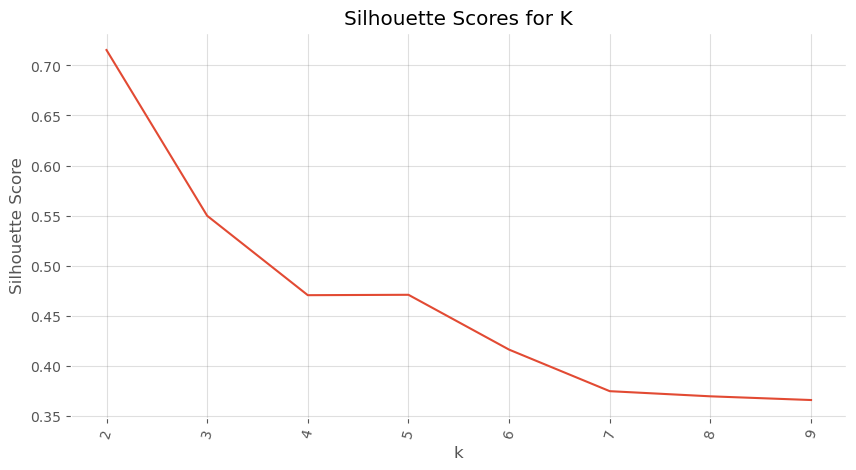

In [32]:
scaler, kmeans, train_regimes, train_feat = compute_regime_clusters(
    df_train,
    n_clusters=None,      # auto choose using silhouette
    atr_window=14,
    vol_windows=[20, 60]
)

In [44]:
df_train_macd =\
(
    assign_regimes(
        df_train,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)
df_train_macd

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,
2007-01-31,1438.239990,1441.609985,1424.780029,1428.650024,2976690000,0.006571,1.051491,0.0
2007-02-01,1445.939941,1446.640015,1437.900024,1437.900024,2914890000,0.005339,1.057120,0.0
2007-02-02,1448.390015,1449.329956,1444.489990,1445.939941,2569450000,0.001693,1.058912,0.0
2007-02-05,1446.989990,1449.380005,1443.849976,1448.329956,2439430000,-0.000967,1.057888,0.0
2007-02-06,1448.000000,1450.189941,1443.400024,1446.979980,2608710000,0.000698,1.058627,0.0
...,...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.013803,2.797399,0.0
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.001008,2.800221,0.0
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.010795,2.830612,0.0


In [45]:
regimes = sorted(df_train_macd["regime"].unique())

regime_dfs = { r: df_train_macd[df_train_macd["regime"] == r].copy()
               for r in regimes }

In [46]:
regimes

[0.0, 1.0]

In [71]:
macd_vol_clustering_hyperparam_df =\
(
    run_macd_hyperparam_search_with_regimes(
        df = df_train_macd,
        price_col='Close',
        regimes = regimes,
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file="data/vol_clustering_with_macd.csv"
    )
)
macd_vol_clustering_hyperparam_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

,short_ma,long_ma,signal,regime,cumulative_return,sharpe
50,6,42,5,0.0,1.748667,0.451060
40,6,37,5,0.0,1.745270,0.448945
130,7,33,5,0.0,1.739293,0.444462
581,13,55,6,0.0,1.719698,0.429352
261,9,46,6,0.0,1.713653,0.429498
...,...,...,...,...,...,...
1776,16,55,15,1.0,0.825558,-0.168664
1865,18,51,13,1.0,0.825558,-0.168664
1489,12,60,20,1.0,0.818578,-0.175740
1659,15,46,20,1.0,0.804439,-0.193186


In [68]:
best_per_regime = (
    macd_vol_clustering_hyperparam_df
    .sort_values("cumulative_return", ascending=False)
    .groupby("regime")
    .head(1)
    .reset_index(drop=True)
)

print(best_per_regime)


   short_ma  long_ma  signal  regime  cumulative_return    sharpe
0        12       42       5     1.0           2.134648  0.423344
1         6       42       5     0.0           0.941531 -0.029656


In [72]:
regime_macd_lookup = {
    row.regime: (row.short_ma, row.long_ma, row.signal)
    for _, row in best_per_regime.iterrows()
}

print(regime_macd_lookup)


{1.0: (12.0, 42.0, 5.0), 0.0: (6.0, 42.0, 5.0)}


In [73]:
vol_clustering_macd_test =\
(
    assign_regimes(
        df_test,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)

vol_clustering_macd_test.head()

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0


In [83]:
for r in regimes:
    df_r = vol_clustering_macd_test[vol_clustering_macd_test["regime"] == r].copy()
    spans = regime_macd_lookup[r]
    df_r = MACD(df_r, spans, price_col='Close', allow_short=False)
    vol_clustering_macd_test.loc[df_r.index, f"signal_r{r}"] = df_r["signal"]

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0
Date,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0,NaN,NaN
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0,NaN,NaN
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0,0.0,NaN
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0,NaN,NaN
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,0.0,NaN,NaN
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,0.0,NaN,NaN
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,0.0,NaN,NaN


In [84]:
signal_cols = [col for col in vol_clustering_macd_test.columns if col.startswith("signal_r")]
signal_cols

['signal_r0.0', 'signal_r1.0']

In [85]:
vol_clustering_macd_test["signal"] =\
(
    vol_clustering_macd_test[signal_cols]
    .bfill(axis=1)
    .iloc[:, 0]
)

In [86]:
vol_clustering_macd_test = generate_position(vol_clustering_macd_test)

<Axes: xlabel='Date'>

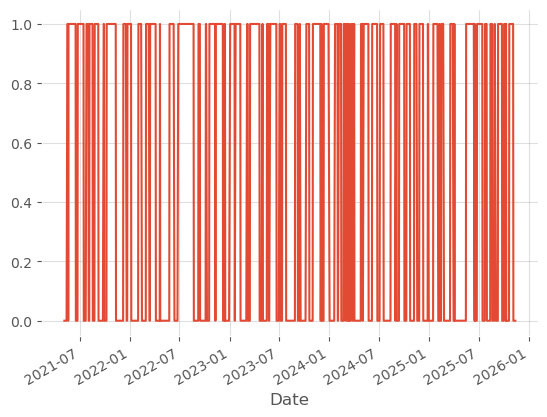

In [87]:
vol_clustering_macd_test['positions'].plot()

In [88]:
vol_clustering_macd_test = compute_portfolio(
    vol_clustering_macd_test,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0,0.0,NaN,0.0,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012


In [89]:
def plot_cumulative_returns(df,
                               date_column = 'Date',
                               strategy_column = 'cumulative_returns_strategy',
                               passive_column = 'cumulative_returns_passive'):
    
    melted = (
        df[[date_column, strategy_column, passive_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={strategy_column: "blue", passive_column: "red"})
        + labs(
            title="Cumulative Returns Comparison",
            x="Date",
            y="Cumulative Return",
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [91]:
(
    plot_cumulative_returns(
        df = vol_clustering_macd_test.reset_index(),
        date_column='Date',
        strategy_column = 'cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )  
)

In [92]:
vol_clustering_macd_metric = \
(
    compute_performance_metrics(
        log_returns=vol_clustering_macd_test['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
vol_clustering_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.01,100901.15,1.009


In [93]:
combined_results.append(vol_clustering_macd_metric)

# 3. Combined Results

In [94]:
(
    pd.concat(
        combined_results,
        axis=0
    )
    .sort_values(by='Final Portfolio Value', ascending=False)
)

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
Buy and Hold,0.125,0.171,0.254,0.776,1.273,0.492,175160.243,1.752
MACD (Base),0.032,0.105,0.174,0.350,0.520,0.183,116013.384,1.160
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.010,100901.150,1.009
MACD with Short (Base),-0.059,0.163,0.392,-0.294,-0.472,-0.152,74751.549,0.748
MACD (Hyperparams),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722
